In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
import torch

import re
import string

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag

import tensorflow as tf
import tensorflow_hub as hub

%matplotlib inline

In [3]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'

In [4]:
embedder = hub.load(module_url)

# Helper functions

In [5]:
def embed(sentence):
  emb_sentence = [sentence]
  return embedder(emb_sentence)

def accuracy(y, y_hat):
  count = 0
  for i in range(len(y)):
    if y[i] == y_hat[i]:
      count += 1
  return count/len(y)
  # return np.mean(y_test == y_hat)

def get_metrics(y, y_hat, print_pos_neg = False):
    if len(y) != len(y_hat):
        print('Two inputs are of differnet length!')
        return null

    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    
    for i in range(len(y)):
        if y[i] == 1:
            if y_hat[i] == 1:
                true_pos += 1
            else:
                false_neg += 1
        else:
            if y_hat[i] == 1:
                false_pos += 1
            else:
                true_neg += 1
    if print_pos_neg:
      print(f'true_pos= {true_pos}, false_neg= {false_neg}, false_pos= {false_pos}, true_neg= {true_neg}')
                
    # Accuracy
    counter = 0
    for i in range(len(y)):
        if y[i] == y_hat[i]:
            counter += 1
    accuracy = round(100 * counter / len(y), 2)
    
    # Precision
    if true_pos == 0 and false_pos == 0:
      precision = 0;
    else:
      precision = round(100 * true_pos / (true_pos + false_pos), 2)
    
    # Sensitivity
    # sensitivity = round(100 * true_pos / (true_pos + false_neg), 2)
    
    # Specificity
    # specifity = round(100 * true_neg / (false_pos + true_neg), 2)
    
    # Recall
    if true_pos == 0 and false_neg == 0:
      recall = 0
    else:
      recall = round(100 * true_pos / (true_pos + false_neg), 2)
    
    # NPV
    # npv = round(100 * true_neg / (true_neg + false_neg), 2)
    
    # F1
    if precision == 0 and recall == 0:
      f1 = 0
    else:
      f1 = round(2 * precision * recall / (precision + recall), 2)

    # return {'accuracy' : accuracy, 'precision' : precision, 'sensitivity' : sensitivity, 'specifity' : specifity, 'recall' : recall, 'npv' : npv, 'f1' : f1}
    return {'accuracy' : accuracy, 'precision' : precision, 'recall' : recall, 'f1' : f1}

# Reading the data

In [6]:
war_vs_trek = pd.read_csv('wars_trek_random.csv', header = 0)
print(war_vs_trek.info())
war_vs_trek.dropna(inplace = True)
war_vs_trek.drop(columns='Unnamed: 0', inplace = True)
print(war_vs_trek.info())
raw_data = war_vs_trek.to_numpy()
raw_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78281 entries, 0 to 78280
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  78281 non-null  int64 
 1   Value       78281 non-null  int64 
 2   Input       77747 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77747 entries, 0 to 78280
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Value   77747 non-null  int64 
 1   Input   77747 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.8+ MB
None


(77747, 2)

# Balancing the data and splitting it into training nd testing sets

In [7]:
print(raw_data.shape)
raw_pos_data = raw_data[raw_data[:, 0] == 1]
raw_neg_data = raw_data[raw_data[:, 0] == 0]
if len(raw_neg_data) < len(raw_pos_data):
  raw_pos_data = np.delete(raw_pos_data, range(len(raw_pos_data) - len(raw_neg_data)), 0)
elif len(raw_pos_data) < len(raw_neg_data):
  raw_neg_data = np.delete(raw_neg_data, range(len(raw_neg_data) - len(raw_pos_data)), 0)
print(raw_pos_data.shape)
print(raw_neg_data.shape)
Pos_neg_test_size = 1 * (raw_neg_data.shape[0] + raw_pos_data.shape[0]) // 10   # I chose to use 80% of the samples for training and 20% for testing.
print(Pos_neg_test_size)
np.random.shuffle(raw_pos_data)
np.random.shuffle(raw_neg_data)
# raw_test_data = np.vstack((raw_pos_data[:(test_size//2),], raw_neg_data[:(test_size//2),]))
raw_test_data = np.vstack((raw_pos_data[:Pos_neg_test_size,], raw_neg_data[:Pos_neg_test_size,])).reshape(2 * Pos_neg_test_size, 2)
# raw_train_data = np.vstack((raw_pos_data[test_size//2:,], raw_neg_data[test_size//2:,]))
raw_train_data = np.vstack((raw_pos_data[Pos_neg_test_size:,], raw_neg_data[Pos_neg_test_size:,])).reshape(len(raw_neg_data) + len(raw_pos_data) - 2 * Pos_neg_test_size, 2)
np.random.shuffle(raw_test_data)
np.random.shuffle(raw_train_data)
print(raw_test_data.shape)
print(raw_train_data.shape)
X_test = raw_test_data[:, 1]
X_train = raw_train_data[:, 1]
y_test = raw_test_data[:, 0]
y_train = raw_train_data[:, 0]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(77747, 2)
(27983, 2)
(27983, 2)
5596
(11192, 2)
(44774, 2)
(44774,)
(11192,)
(44774,)
(11192,)


In [8]:
for i in range(X_train.shape[0]):
  if X_train[i] == '':
    print('i=', i, ':', X_train[i])

In [9]:
# First convert to lower case:
for i in range(len(X_train)):
  try:
    X_train[i] = X_train[i].lower()
  except:
    print('Error!')
for i in range(len(X_test)):
  try:
    X_test[i] = X_test[i].lower()
  except:
    print('Error!')

In [10]:
# Second remove links:
for i in range(len(X_train)):
  X_train[i] = re.sub(r'http\S+', '', X_train[i])
for i in range(len(X_test)):
  X_test[i] = re.sub(r'http\S+', '', X_test[i])
print(X_train.shape)
print(X_test.shape)

(44774,)
(11192,)


In [ ]:
# results = {}
# for i in range(len(ugly_words)): 
#     result = re.findall(r'\s\w*\.{3}', ugly_words[i])
# #     result = re.findall(r'\s\w*\.\.\.', ugly_words[i])
#     if result != []:
#         results[i] = result
# print(len(results))
# print(results)

In [ ]:
# my_list = {1: [' disea...', ' disease'], 135: [' poss...', 'possible'], [303, 1011] : [' mediterran...', ' mediterranean'],
#            551: [' tr...', 'trapped'], 563 : [' learni...', ' learning'], 558 : [' cow...', 'cow'],
#            582 : [' oi...', ' oil'], [584, 1611] : [' ut...', 'utterly'], 705 : [' cleav...', 'cleavage'],
#            1013 : [' see...', 'see'], [1018, 1046, 1034] : [' sh...', 'shooting'], 1196 : [' mothe...', 'mother'],
#            1304 : [' accepte...', ' accepted'], 1467 : [' has...', ' has'], 1512 : [' anna...', ' anna'],
#            1572 : [' cr...', ' crash'], 1749 : [' exp...', ' experts'], 1755 : [' bang...', ' bang']}
# len(my_list)

In [11]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
print(X_train[0])
print(X_test[0])

they converge onto the narrow path leading into the
rey i saw myself on the dark throne i won   let it happen i  m never leaving this place i  m doing what you did


In [13]:
raw_X_train = []
raw_X_test = []
for i in range(len(X_train)):
  raw_X_train.append("".join([char for char in X_train[i] if char not in string.punctuation]))
for i in range(len(X_test)):
  raw_X_test.append("".join([char for char in X_test[i] if char not in string.punctuation]))

raw_X_train = np.asarray(raw_X_train)
raw_X_test = np.asarray(raw_X_test)

In [14]:
print(raw_X_train.shape)
print(raw_X_test.shape)

(44774,)
(11192,)


In [15]:
X_train = []
for x in raw_X_train:
  X_train.append(tf.reshape(embed(x), [512]))
X_train = np.array(X_train)

In [16]:
X_test = []
for x in raw_X_test:
  X_test.append(tf.reshape(embed(x), [512]))
X_test = np.array(X_test)

In [66]:
# pd.DataFrame(data = X_train).to_csv('X_train.csv')
# pd.DataFrame(data = X_test).to_csv('X_test.csv')
# pd.DataFrame(data = y_train).to_csv('y_train.csv')
# pd.DataFrame(data = y_test).to_csv('y_test.csv')
X_train = pd.read_csv("X_train.csv", delimiter=',').to_numpy()
X_test = pd.read_csv("X_test.csv", delimiter=',').to_numpy()
y_train = pd.read_csv("y_train.csv", delimiter=',').to_numpy()
y_test = pd.read_csv("y_test.csv", delimiter=',').to_numpy()

In [67]:
X_train = X_train[:, 1:]
X_test = X_test[:, 1:]
y_train = y_train[:, 1]
y_test = y_test[:, 1]

In [68]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

(44774, 512)
(11192, 512)
(44774,)
(11192,)
[0 0 1 ... 0 1 0]


#Fitting a Non-naive Gaussian Bayes Classifier

In [69]:
class GenBayes():
    
    def fit(self, X, y, epsilon = 1e-3):
        N, D = X.shape
        
        self.likelihoods = dict()
        self.priors = dict()
        
        # sometimes y is float or boolean, etc. So we make sure they are converted into ints
        self.K = set(y.astype(int))

        print(X.shape)
        print(y.shape)
        for k in self.K:
            X_k = X[y == k,:]
            N_k, D = X_k.shape
            mu_k=X_k.mean(axis=0)

            self.likelihoods[k] = {"mean":X_k.mean(axis=0), "cov":(1/(N_k-1))*np.matmul((X_k-mu_k).T,X_k-mu_k)+ epsilon*np.identity(D)}
            self.priors[k] = len(X_k)/len(X)
        return

    def predict(self, X):
        N, D = X.shape
        P_hat = np.zeros((N,len(self.K)))

        for k, l in self.likelihoods.items():
            P_hat[:,k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])
        return P_hat.argmax(axis = 1)

In [70]:
gb = GenBayes()

gb.fit(X_train, y_train)
y_hat = gb.predict(X_test)
print(f'Non-Naiv Gaussian Bayes accuracy= {(100 * accuracy(y_test, y_hat)):.2f}%')

(44774, 512)
(44774,)
Non-Naiv Gaussian Bayes accuracy= 89.56%


# Training an Artificial Neura Network

##Activation and Helper functions

In [55]:
def linear(H):
  return H

def ReLU(H):
  # t avoid using max function
  return H * (H > 0)

def sigmoid(H):
  return 1/(1 + np.exp(-H))

def softmax(H):
  eH = np.exp(H)
  # keepdims is for keeping the dimensions.
  return eH/eH.sum(axis = 1, keepdims = True)

def cross_entropy(Y, P_hat):
  return -(1/len(Y)) * np.sum(Y * np.log(P_hat))

def OLS(Y, Y_hat):
  return (1/(2*len(Y))) * np.sum((Y - Y_hat)**2)

def one_hot_encode(y):
  N = len(y)
  K = len(set(y))

  Y = np.zeros((N, K))
  for i in range(N):
    Y[i, y[i]] = 1

  return Y

def accuracy(y, y_hat):
  return np.mean(y == y_hat)

def R2(y, y_hat):
  return 1 - np.sum((y - y_hat) ** 2) / np.sum((y - y.mean()) ** 2)

# We define this function to generalize what we did for the two layer 
def derivative(Z, a):
  if a == linear:
    return 1

  elif a == sigmoid:
    return Z * (1 - Z)

  elif a == np.tanh:
    return 1 - Z * Z

  elif a == ReLU:
    return (Z > 0).astype(int)
  else:
    VlueError('Unknown Activation Function')

In [73]:
class ANN():

  def __init__(self, architecture, activations = None, mode = 0):
    self.mode = mode
    self.architecture = architecture
    self.activations = activations
    self.L = len(architecture) + 1

  def fit(self, X, y, X_test, y_test, eta = 1e-3, epochs = 1e3, show_curve = False, measure_metrics = False):
    epochs = int(epochs)

    if self.mode:
      Y = y
    else:
      Y = one_hot_encode(y)

    N, D = X.shape
    K = Y.shape[1]

    # Weight and bias initialization:
    self.W = {l : np.random.randn(M[0], M[1]) for l, M in enumerate(zip(([D] + self.architecture) , (self.architecture + [K])), 1)}
    self.b = {l : np.random.randn(M) for l, M in enumerate(self.architecture + [K], 1)}

    # Activation function loading:
    if self.architecture is None:
      self.a = {l : ReLU for l in range(1, self.L)}
    else:
      self.a = {l : act for l, act in enumerate(self.activations, 1)}

    # Mode set:
    if self.mode:
      self.a[self.L] = linear
    else:
      self.a[self.L] = softmax

    J = np.zeros(epochs)

    # print('Test3')
    accuracy_train_hist = []
    accuracy_test_hist = []
    loss_hist = []
    # Gradient Descent:
    for epoch in range(epochs):
      # if epoch == epochs / 6:
      #   eta /=10
      # if epoch == epochs / 2:
      #   eta /=10
      # if epoch == 3 * epochs / 4:
      #   eta /=10

      self.forward(X)
      # print('Test4')
      if self.mode:
        J[epoch] = OLS(Y, self.Z[self.L])
      else:
        J[epoch] = cross_entropy(Y, self.Z[self.L])

      # We now define the differential element of H:
      dH = (1/N) * (self.Z[self.L] - Y)

      # Here we assign our weight and bias upate rules (Back-propagation).
      for l in sorted(self.W.keys(), reverse = True):
        dW = self.Z[l - 1].T @ dH
        db = dH.sum(axis = 0)

        self.W[l] -= eta * dW
        self.b[l] -= eta * db

        if l > 1:
          dZ = dH @ self.W[l].T
          dH = dZ * derivative(self.Z[l-1], self.a[l - 1])
      
      if measure_metrics:
        accuracy_train_hist.append(get_metrics(y_train, self.predict(X_train))['accuracy'])
        accuracy_test_hist.append(get_metrics(y_test, self.predict(X_test))['accuracy'])
        # loss_hist.append(self.a[self.L](self.Z[self.L - 1] @ self.W[self.L] + self.b[self.L]) / y_train)

    if show_curve:
      plt.figure()
      plt.plot(J)
      plt.xlabel('epochs')
      plt.ylabel('$\mathcal{J}$')
      plt.title('Training Curve')
      plt.show()

    return accuracy_train_hist, accuracy_test_hist
    
  def forward(self, X):
    self.Z = {0: X}

    for l in sorted(self.W.keys()):
      self.Z[l] = self.a[l](self.Z[l - 1] @ self.W[l] + self.b[l])
  
  def predict(self, X):
    self.forward(X)

    if self.mode:
      # Returns the output of the last layer of the network which is the final output.
      return self.Z[self.L]
    else:
      # This is to prform softmax function:
      return self.Z[self.L].argmax(axis = 1)

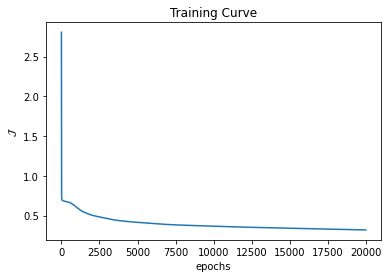

Training metrics:
true_pos= 17710, false_neg= 4677, false_pos= 1229, true_neg= 21158
{'accuracy': 86.81, 'precision': 93.51, 'recall': 79.11, 'f1': 85.71}
Testing metrics:
true_pos= 4384, false_neg= 1212, false_pos= 402, true_neg= 5194
{'accuracy': 85.58, 'precision': 91.6, 'recall': 78.34, 'f1': 84.45}


In [ ]:
myAnn = ANN([8, 8, 8, 8, 8], [ReLU, np.tanh, np.tanh, np.tanh, np.tanh])
accuracy_train_hist, accuracy_test_hist = myAnn.fit(X_train, y_train, X_test, y_test, eta = 5e-2, epochs = 2e4, show_curve = True, measure_metrics = True)
y_hat_train_5_8_8_8_8_8_tanh_1_1_1_4 = myAnn.predict(X_train)
y_hat_test_5_8_8_8_8_8_tanh_1_1_1_4 = myAnn.predict(X_test)
print('Training metrics:')
print(get_metrics(y_train, y_hat_train_5_8_8_8_8_8_tanh_1_1_1_4, print_pos_neg = True))
print('Testing metrics:')
print(get_metrics(y_test, y_hat_test_5_8_8_8_8_8_tanh_1_1_1_4, print_pos_neg = True))

In [ ]:
myAnn = ANN([64, 64, 32, 32], [ReLU, np.tanh, np.tanh, sigmoid])
accuracy_train_hist, accuracy_test_hist = myAnn.fit(X_train, y_train, X_test, y_test, eta = 5e-2, epochs = 1e4, show_curve = True, measure_metrics = True)
y_hat_train_4_64_64_32_32_tanh_1_1_1_4_v2 = myAnn.predict(X_train)
y_hat_test_4_64_64_32_32_tanh_1_1_1_4_v2 = myAnn.predict(X_test)
print('Training metrics:')
print(get_metrics(y_train, y_hat_train_4_64_64_32_32_tanh_1_1_1_4_v2, print_pos_neg = True))
print('Testing metrics:')
print(get_metrics(y_test, y_hat_test_4_64_64_32_32_tanh_1_1_1_4_v2, print_pos_neg = True))

Streaming output truncated to the last 5000 lines.
 [-1.23199072  0.03976416]
 [ 0.88328797  1.38457918]]
[[ 3.0939543   2.09094478]
 [ 0.13344093  1.42948405]
 [-1.39034674  1.38224278]
 ...
 [ 3.16498576 -0.68269424]
 [-1.23220109  0.03978803]
 [ 0.88327888  1.38459361]]
[[-0.19076134  1.3662066 ]
 [ 3.72130263  5.95469692]
 [ 5.25112476  0.54134478]
 ...
 [ 1.23466173  4.27947623]
 [ 4.14886023  1.27633857]
 [ 6.2344359   2.70288403]]
[[ 3.0939543   2.09094478]
 [ 0.13344093  1.42948405]
 [-1.39034674  1.38224278]
 ...
 [ 3.16498576 -0.68269424]
 [-1.23220109  0.03978803]
 [ 0.88327888  1.38459361]]
[[ 3.09404552  2.09103293]
 [ 0.13345499  1.42959568]
 [-1.3898196   1.38203026]
 ...
 [ 3.16502835 -0.68264777]
 [-1.23239263  0.0398128 ]
 [ 0.88326415  1.38460837]]
[[-0.19110239  1.36598319]
 [ 3.7208726   5.95495231]
 [ 5.25111052  0.541492  ]
 ...
 [ 1.23455533  4.27951321]
 [ 4.14910188  1.27625993]
 [ 6.23431951  2.7027654 ]]
[[ 3.09404552  2.09103293]
 [ 0.13345499  1.42959568]


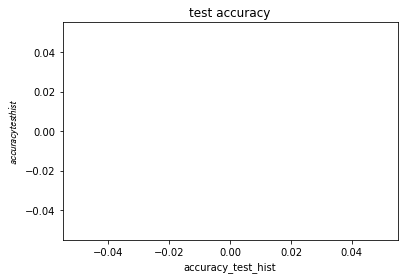

In [ ]:
plt.figure()
plt.plot(accuracy_train_hist)
plt.xlabel('accuracy_train_hist')
plt.ylabel('$\mathcal{accuracy train hist}$')
plt.title('train accuracy')

plt.plot(accuracy_test_hist)
plt.xlabel('accuracy_test_hist')
plt.ylabel('$\mathcal{accuracy test hist}$')
plt.title('test accuracy')
plt.show()

In [ ]:
print(accuracy_train_hist)

[]


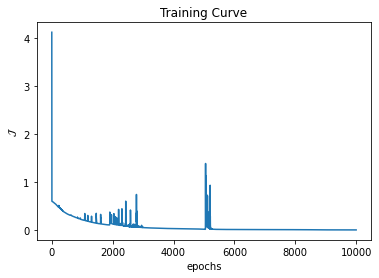

(364,)
ANN testing accuracy: 86.54%


In [ ]:
myAnn = ANN([8, 8, 8, 8], [ReLU, np.tanh, np.tanh, np.tanh])
myAnn.fit(X_train, y_train, eta = 3e-1, epochs = 1e4, show_curve = True)
y_hat_4_tanh_3_1_1_4 = myAnn.predict(X_test)
print(y_test.shape)
print(get_metrics(y_test, y_hat_4_tanh_3_1_1_4))
print(f'ANN testing accuracy: {(100 * accuracy(y_test, y_hat_4_tanh_3_1_1_4)):0.2f}%')

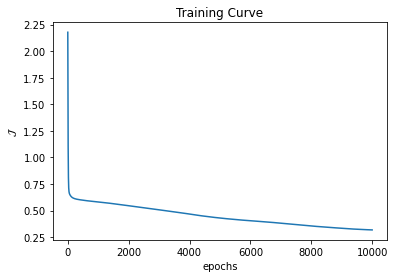

(364,)
true_pos= 61, false_neg= 27, false_pos= 49, true_neg= 227
{'accuracy': 79.12, 'precision': 0.5545, 'sensitivity': 0.6932, 'specifity': 0.8225, 'recall': 0.6932, 'npv': 0.8937, 'f1': 0.6161}


In [ ]:
myAnn = ANN([8, 8, 8, 8], [ReLU, np.tanh, np.tanh, sigmoid])
myAnn.fit(X_train, y_train, eta = 3e-2, epochs = 2e4, show_curve = True)
y_hat_4_sigmoid_3_2_2_4 = myAnn.predict(X_test)
print(y_test.shape)
print(get_metrics(y_test, y_hat_4_sigmoid_3_2_2_4))
# print(f'ANN testing accuracy: {(100 * accuracy(y_test, y_hat_3_2)):0.2f}%')

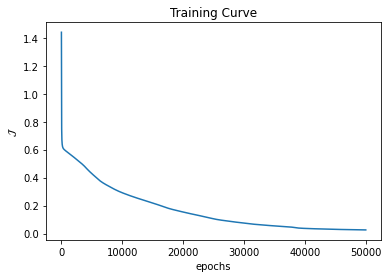

(364,)
true_pos= 64, false_neg= 24, false_pos= 37, true_neg= 239
{'accuracy': 83.24, 'precision': 0.6337, 'sensitivity': 0.7273, 'specifity': 0.8659, 'recall': 0.7273, 'npv': 0.9087, 'f1': 0.6773}


In [ ]:
myAnn = ANN([8, 8, 8, 8], [ReLU, np.tanh, np.tanh, sigmoid])
myAnn.fit(X_train, y_train, eta = 3e-2, epochs = 5e4, show_curve = True)
y_hat_4_sigmoid_3_2_5_4 = myAnn.predict(X_test)
print(y_test.shape)
print(get_metrics(y_test, y_hat_4_sigmoid_3_2_5_4))

In [ ]:
train_positive_count = len(X_train[y_train == 1])
train_negative = X_train[y_train == 0]
y_train_negative = y_train[y_train == 0]
train_negative_count = len(train_negative)
if train_positive_count < train_negative_count:
  train_negative_count = train_positive_count
  # train_negative_count = min(train_negative_count, int(train_positive_count * 1.5))
  bal_train_negative = train_negative[0:train_negative_count, :]
  bal_y_train_negative = y_train_negative[0:train_negative_count]
  # print(bal_train_negative.shape)
  # print(bal_y_train_negative.shape)
  # print(y_train[y_train == 1].shape)
  X_bal_train = np.vstack((X_train[y_train == 1], bal_train_negative))
  y_bal_train = np.hstack((y_train[y_train == 1], bal_y_train_negative))
  print(X_bal_train.shape)
  print(y_bal_train.shape)  

(880, 512)
(880,)


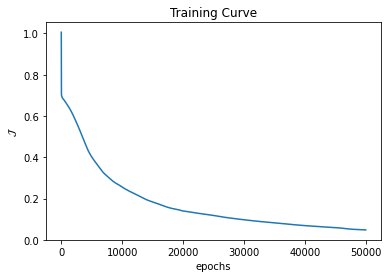

(364,)
true_pos= 75, false_neg= 13, false_pos= 58, true_neg= 218


NameError: ignored

In [ ]:
myAnn = ANN([8, 8, 8, 8], [ReLU, np.tanh, np.tanh, sigmoid])
myAnn.fit(X_bal_train, y_bal_train, eta = 3e-2, epochs = 5e4, show_curve = True)
y_hat_bal_4_sigmoid_3_2_5_4 = myAnn.predict(X_test)
print(y_test.shape)
print(get_metrics(y_test, y_hat_bal_4_sigmoid_3_2_5_4))

In [ ]:
print(get_metrics(y_test, y_hat_bal_4_sigmoid_3_2_5_4))

true_pos= 75, false_neg= 13, false_pos= 58, true_neg= 218
{'accuracy': 80.49, 'precision': 56.39, 'recall': 85.23, 'f1': 67.87}


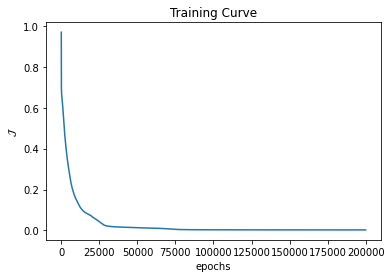

(364,)
true_pos= 79, false_neg= 9, false_pos= 67, true_neg= 209
{'accuracy': 79.12, 'precision': 54.11, 'recall': 89.77, 'f1': 67.52}


In [ ]:
myAnn = ANN([8, 8, 8, 8], [ReLU, np.tanh, np.tanh, sigmoid])
myAnn.fit(X_bal_train, y_bal_train, eta = 3e-2, epochs = 2e5, show_curve = True)
y_hat_bal_4_sigmoid_3_2_2_5 = myAnn.predict(X_test)
print(y_test.shape)
print(get_metrics(y_test, y_hat_bal_4_sigmoid_3_2_2_5))

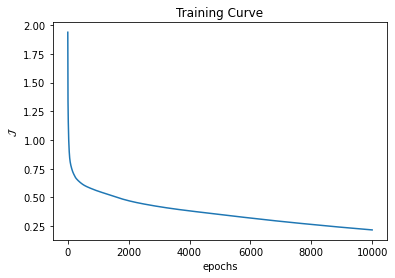

(364,)
true_pos= 75, false_neg= 13, false_pos= 74, true_neg= 202
{'accuracy': 76.1, 'precision': 50.34, 'recall': 85.23, 'f1': 63.3}


In [ ]:
myAnn = ANN([16, 8, 8, 16], [ReLU, np.tanh, np.tanh, np.tanh])
myAnn.fit(X_bal_train, y_bal_train, eta = 1e-2, epochs = 1e4, show_curve = True)
y_hat_4_16_8_8_16_tanh_1_2_1_4 = myAnn.predict(X_test)
print(y_test.shape)
print(get_metrics(y_test, y_hat_4_16_8_8_16_tanh_1_2_1_4))

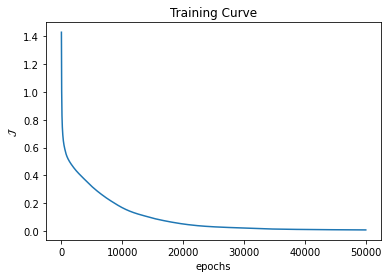

(364,)
true_pos= 65, false_neg= 23, false_pos= 109, true_neg= 167
{'accuracy': 63.74, 'precision': 37.36, 'recall': 73.86, 'f1': 49.62}


In [ ]:
myAnn = ANN([16, 16, 16, 16], [ReLU, np.tanh, np.tanh, np.tanh])
myAnn.fit(X_bal_train, y_bal_train, eta = 1e-2, epochs = 5e4, show_curve = True)
y_hat_4_16_16_16_16_tanh_1_2_5_4 = myAnn.predict(X_test)
print(y_test.shape)
print(get_metrics(y_test, y_hat_4_16_16_16_16_tanh_1_2_5_4))

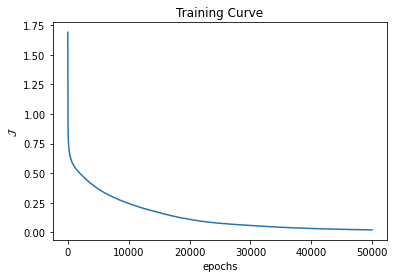

(364,)
true_pos= 76, false_neg= 12, false_pos= 66, true_neg= 210
{'accuracy': 78.57, 'precision': 53.52, 'recall': 86.36, 'f1': 66.09}


In [ ]:
myAnn = ANN([16, 16, 16, 16], [ReLU, np.tanh, np.tanh, sigmoid])
myAnn.fit(X_bal_train, y_bal_train, eta = 1e-2, epochs = 5e4, show_curve = True)
y_hat_4_16_16_16_16_sigmoid_1_2_5_4 = myAnn.predict(X_test)
print(y_test.shape)
print(get_metrics(y_test, y_hat_4_16_16_16_16_sigmoid_1_2_5_4))

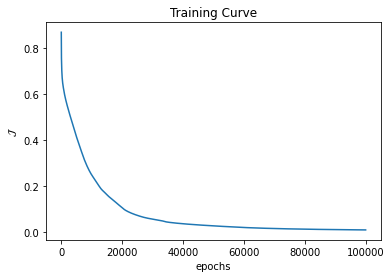

(364,)
true_pos= 71, false_neg= 17, false_pos= 69, true_neg= 207
{'accuracy': 76.37, 'precision': 50.71, 'recall': 80.68, 'f1': 62.28}


In [ ]:
myAnn = ANN([16, 16, 16, 16], [ReLU, np.tanh, np.tanh, sigmoid])
myAnn.fit(X_bal_train, y_bal_train, eta = 1e-2, epochs = 1e5, show_curve = True)
y_hat_4_16_16_16_16_sigmoid_1_2_1_5 = myAnn.predict(X_test)
print(y_test.shape)
print(get_metrics(y_test, y_hat_4_16_16_16_16_sigmoid_1_2_1_5))

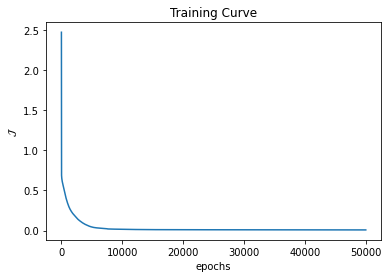

(364,)
true_pos= 74, false_neg= 14, false_pos= 63, true_neg= 213
{'accuracy': 78.85, 'precision': 54.01, 'recall': 84.09, 'f1': 65.77}


In [ ]:
myAnn = ANN([8, 8, 8, 8], [ReLU, np.tanh, np.tanh, np.tanh])
myAnn.fit(X_bal_train, y_bal_train, eta = 1e-1, epochs = 5e4, show_curve = True)
y_hat_4_8_8_8_8_tanh_1_1_5_4 = myAnn.predict(X_test)
print(y_test.shape)
print(get_metrics(y_test, y_hat_4_8_8_8_8_tanh_1_1_5_4))

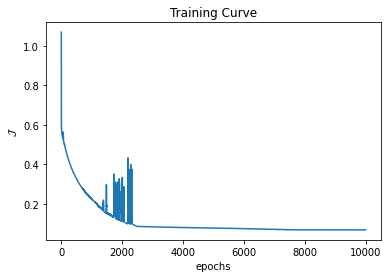

(364,)


NameError: ignored

In [ ]:
myAnn = ANN([8, 8, 8, 8], [ReLU, np.tanh, np.tanh, np.tanh])
myAnn.fit(X_train, y_train, eta = 3e-1, epochs = 1e4, show_curve = True)
y_hat_4_8_8_8_8_tanh_3_1_1_4 = myAnn.predict(X_test) # eta tuning at (epochs / 4) and (3 * epochs / 4)
print(y_test.shape)
print(get_metrics(y_test, y_hat_4_8_8_8_8_tanh_3_1_1_4))

In [ ]:
print(get_metrics(y_test, y_hat_4_8_8_8_8_tanh_3_1_1_4))

true_pos= 69, false_neg= 19, false_pos= 36, true_neg= 240
{'accuracy': 84.89, 'precision': 65.71, 'recall': 78.41, 'f1': 71.5}


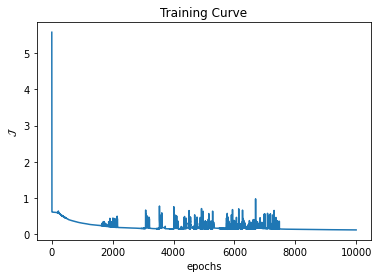

Training metrics:
true_pos= 419, false_neg= 21, false_pos= 18, true_neg= 1042
{'accuracy': 97.4, 'precision': 95.88, 'recall': 95.23, 'f1': 95.55}
Testing metrics:
true_pos= 75, false_neg= 13, false_pos= 32, true_neg= 244
{'accuracy': 87.64, 'precision': 70.09, 'recall': 85.23, 'f1': 76.92}


In [ ]:
myAnn = ANN(8, 8, 8, 8],[ [ReLU, np.tanh, np.tanh, np.tanh])
accuracy_train_hist, accuracy_test_hist = myAnn.fit(X_train, y_train, X_test, y_test, eta = 3e-1, epochs = 1e4, show_curve = True, measure_metrics = True)
y_hat_train_4_8_8_8_8_tanh_3_1_1_4_v2 = myAnn.predict(X_train) # eta tuning at (epochs / 6) and (3 * epochs / 4)
y_hat_4_8_8_8_8_tanh_3_1_1_4_v2 = myAnn.predict(X_test) # eta tuning at (epochs / 6) and (3 * epochs / 4)
print('Training metrics:')
print(get_metrics(y_train, y_hat_train_4_8_8_8_8_tanh_3_1_1_4_v2, print_pos_neg = True))
print('Testing metrics:')
print(get_metrics(y_test, y_hat_4_8_8_8_8_tanh_3_1_1_4_v2, print_pos_neg = True))

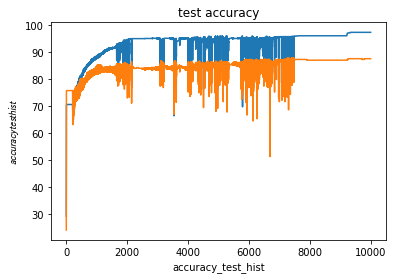

In [ ]:
plt.figure()
plt.plot(accuracy_train_hist)
plt.xlabel('accuracy_train_hist')
plt.ylabel('$\mathcal{accuracy train hist}$')
plt.title('train accuracy')

plt.plot(accuracy_test_hist)
plt.xlabel('accuracy_test_hist')
plt.ylabel('$\mathcal{accuracy test hist}$')
plt.title('test accuracy')
plt.show()

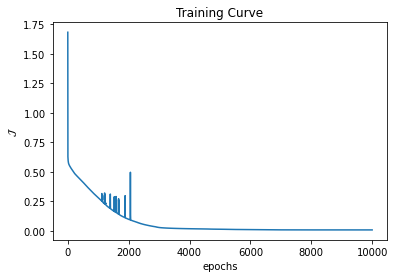

Training metrics:
true_pos= 438, false_neg= 2, false_pos= 2, true_neg= 1058
{'accuracy': 99.73, 'precision': 99.55, 'recall': 99.55, 'f1': 99.55}
Testing metrics:
true_pos= 67, false_neg= 21, false_pos= 51, true_neg= 225
{'accuracy': 80.22, 'precision': 56.78, 'recall': 76.14, 'f1': 65.05}


In [ ]:
myAnn = ANN([6, 6, 6, 6], [ReLU, np.tanh, np.tanh, np.tanh])
accuracy_train_hist, accuracy_test_hist = myAnn.fit(X_train, y_train, X_test, y_test, eta = 3e-1, epochs = 1e4, show_curve = True, measure_metrics = True)
y_hat_train_4_6_6_6_6_tanh_3_1_1_4_v2 = myAnn.predict(X_train) # eta tuning at (epochs / 6) and (3 * epochs / 4)
y_hat_4_6_6_6_6_tanh_3_1_1_4_v2 = myAnn.predict(X_test) # eta tuning at (epochs / 6) and (3 * epochs / 4)
print('Training metrics:')
print(get_metrics(y_train, y_hat_train_4_6_6_6_6_tanh_3_1_1_4_v2, print_pos_neg = True))
print('Testing metrics:')
print(get_metrics(y_test, y_hat_4_6_6_6_6_tanh_3_1_1_4_v2, print_pos_neg = True))

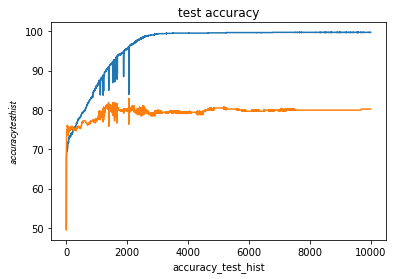

In [ ]:
plt.figure()
plt.plot(accuracy_train_hist)
plt.xlabel('accuracy_train_hist')
plt.ylabel('$\mathcal{accuracy train hist}$')
plt.title('train accuracy')

plt.plot(accuracy_test_hist)
plt.xlabel('accuracy_test_hist')
plt.ylabel('$\mathcal{accuracy test hist}$')
plt.title('test accuracy')
plt.show()

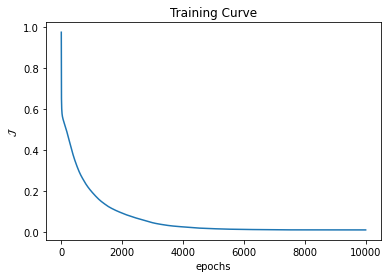

Training metrics:
true_pos= 438, false_neg= 2, false_pos= 3, true_neg= 1057
{'accuracy': 99.67, 'precision': 99.32, 'recall': 99.55, 'f1': 99.43}
Testing metrics:
true_pos= 70, false_neg= 18, false_pos= 49, true_neg= 227
{'accuracy': 81.59, 'precision': 58.82, 'recall': 79.55, 'f1': 67.63}


In [ ]:
myAnn = ANN([8, 8, 8], [ReLU, np.tanh, np.tanh])
accuracy_train_hist, accuracy_test_hist = myAnn.fit(X_train, y_train, X_test, y_test, eta = 3e-1, epochs = 1e4, show_curve = True, measure_metrics = True)
y_hat_train_3_8_8_8_tanh_3_1_1_4_v2 = myAnn.predict(X_train) # eta tuning at (epochs / 6) and (3 * epochs / 4)
y_hat_test_3_8_8_8_tanh_3_1_1_4_v2 = myAnn.predict(X_test) # eta tuning at (epochs / 6) and (3 * epochs / 4)
print('Training metrics:')
print(get_metrics(y_train, y_hat_train_3_8_8_8_tanh_3_1_1_4_v2, print_pos_neg = True))
print('Testing metrics:')
print(get_metrics(y_test, y_hat_test_3_8_8_8_tanh_3_1_1_4_v2, print_pos_neg = True))

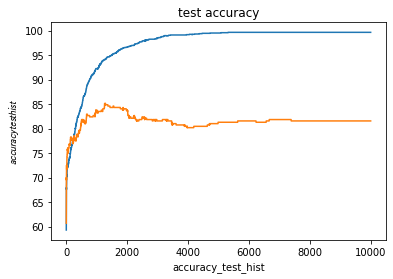

In [ ]:
plt.figure()
plt.plot(accuracy_train_hist)
plt.xlabel('accuracy_train_hist')
plt.ylabel('$\mathcal{accuracy train hist}$')
plt.title('train accuracy')

plt.plot(accuracy_test_hist)
plt.xlabel('accuracy_test_hist')
plt.ylabel('$\mathcal{accuracy test hist}$')
plt.title('test accuracy')
plt.show()

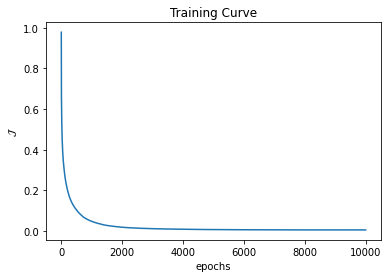

Training metrics:


NameError: ignored

In [ ]:
myAnn = ANN([64, 64, 32, 32], [ReLU, np.tanh, np.tanh, sigmoid])
accuracy_train_hist, accuracy_test_hist = myAnn.fit(X_train, y_train, X_test, y_test, eta = 3e-1, epochs = 1e4, show_curve = True, measure_metrics = True)
y_hat_train_4_64_64_32_32_sigmoid_3_1_1_4_v2 = myAnn.predict(X_train) # eta tuning at (epochs / 6) and (3 * epochs / 4)
y_hat_test_4_64_64_32_32_sigmoid_3_1_1_4_v2 = myAnn.predict(X_test) # eta tuning at (epochs / 6) and (3 * epochs / 4)
print('Training metrics:')
print(get_metrics(y_train, y_hat_train_4_64_64_32_32_sigmoid_3_1_1_4_v2, print_pos_neg = True))
print('Testing metrics:')
print(get_metrics(y_test, y_hat_test_4_64_64_32_32_sigmoid_3_1_1_4_v2, print_pos_neg = True))

In [ ]:
print('Training metrics:')
print(get_metrics(y_train, y_hat_train_4_64_64_32_32_sigmoid_3_1_1_4_v2, print_pos_neg = True))
print('Testing metrics:')
print(get_metrics(y_test, y_hat_test_4_64_64_32_32_sigmoid_3_1_1_4_v2, print_pos_neg = True))

Training metrics:
true_pos= 440, false_neg= 0, false_pos= 3, true_neg= 1057
{'accuracy': 99.8, 'precision': 99.32, 'recall': 100.0, 'f1': 99.66}
Testing metrics:
true_pos= 57, false_neg= 31, false_pos= 48, true_neg= 228
{'accuracy': 78.3, 'precision': 54.29, 'recall': 64.77, 'f1': 59.07}


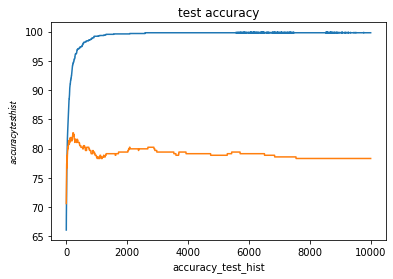

In [ ]:
plt.figure()
plt.plot(accuracy_train_hist)
plt.xlabel('accuracy_train_hist')
plt.ylabel('$\mathcal{accuracy train hist}$')
plt.title('train accuracy')

plt.plot(accuracy_test_hist)
plt.xlabel('accuracy_test_hist')
plt.ylabel('$\mathcal{accuracy test hist}$')
plt.title('test accuracy')
plt.show()

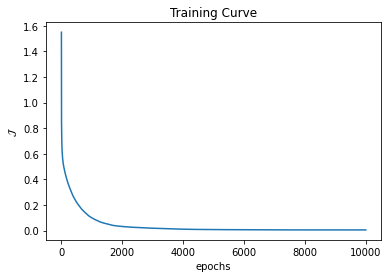

Training metrics:
true_pos= 439, false_neg= 1, false_pos= 2, true_neg= 1058
{'accuracy': 99.8, 'precision': 99.55, 'recall': 99.77, 'f1': 99.66}
Testing metrics:
true_pos= 56, false_neg= 32, false_pos= 50, true_neg= 226
{'accuracy': 77.47, 'precision': 52.83, 'recall': 63.64, 'f1': 57.73}


In [ ]:
myAnn = ANN([32, 32, 16, 16], [ReLU, np.tanh, np.tanh, sigmoid])
accuracy_train_hist, accuracy_test_hist = myAnn.fit(X_train, y_train, X_test, y_test, eta = 3e-1, epochs = 1e4, show_curve = True, measure_metrics = True)
y_hat_train_4_32_32_16_16_sigmoid_3_1_1_4_v2 = myAnn.predict(X_train) # eta tuning at (epochs / 6) and (3 * epochs / 4)
y_hat_test_4_32_32_16_16_sigmoid_3_1_1_4_v2 = myAnn.predict(X_test) # eta tuning at (epochs / 6) and (3 * epochs / 4)
print('Training metrics:')
print(get_metrics(y_train, y_hat_train_4_32_32_16_16_sigmoid_3_1_1_4_v2, print_pos_neg = True))
print('Testing metrics:')
print(get_metrics(y_test, y_hat_test_4_32_32_16_16_sigmoid_3_1_1_4_v2, print_pos_neg = True))

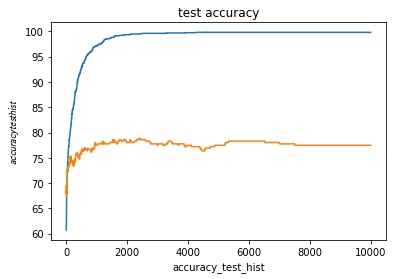

In [ ]:
plt.figure()
plt.plot(accuracy_train_hist)
plt.xlabel('accuracy_train_hist')
plt.ylabel('$\mathcal{accuracy train hist}$')
plt.title('train accuracy')

plt.plot(accuracy_test_hist)
plt.xlabel('accuracy_test_hist')
plt.ylabel('$\mathcal{accuracy test hist}$')
plt.title('test accuracy')
plt.show()

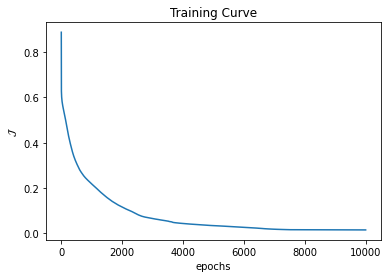

Training metrics:
true_pos= 435, false_neg= 5, false_pos= 2, true_neg= 1058
{'accuracy': 99.53, 'precision': 99.54, 'recall': 98.86, 'f1': 99.2}
Testing metrics:
true_pos= 62, false_neg= 26, false_pos= 37, true_neg= 239
{'accuracy': 82.69, 'precision': 62.63, 'recall': 70.45, 'f1': 66.31}


In [ ]:
myAnn = ANN([16, 16, 8, 8], [ReLU, np.tanh, np.tanh, sigmoid])
accuracy_train_hist, accuracy_test_hist = myAnn.fit(X_train, y_train, X_test, y_test, eta = 3e-1, epochs = 1e4, show_curve = True, measure_metrics = True)
y_hat_train_4_16_16_8_8_sigmoid_3_1_1_4_v2 = myAnn.predict(X_train)
y_hat_test_4_16_16_8_8_sigmoid_3_1_1_4_v2 = myAnn.predict(X_test)
print('Training metrics:')
print(get_metrics(y_train, y_hat_train_4_16_16_8_8_sigmoid_3_1_1_4_v2, print_pos_neg = True))
print('Testing metrics:')
print(get_metrics(y_test, y_hat_test_4_16_16_8_8_sigmoid_3_1_1_4_v2, print_pos_neg = True))

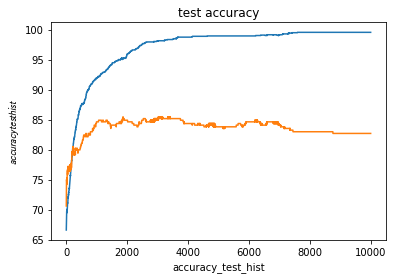

In [ ]:
plt.figure()
plt.plot(accuracy_train_hist)
plt.xlabel('accuracy_train_hist')
plt.ylabel('$\mathcal{accuracy train hist}$')
plt.title('train accuracy')

plt.plot(accuracy_test_hist)
plt.xlabel('accuracy_test_hist')
plt.ylabel('$\mathcal{accuracy test hist}$')
plt.title('test accuracy')
plt.show()

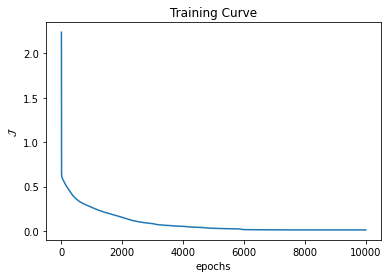

Training metrics:
true_pos= 439, false_neg= 1, false_pos= 4, true_neg= 1056
{'accuracy': 99.67, 'precision': 99.1, 'recall': 99.77, 'f1': 99.43}
Testing metrics:
true_pos= 63, false_neg= 25, false_pos= 47, true_neg= 229
{'accuracy': 80.22, 'precision': 57.27, 'recall': 71.59, 'f1': 63.63}


In [ ]:
myAnn = ANN([8, 8, 6, 6], [ReLU, np.tanh, np.tanh, sigmoid])
accuracy_train_hist, accuracy_test_hist = myAnn.fit(X_train, y_train, X_test, y_test, eta = 3e-1, epochs = 1e4, show_curve = True, measure_metrics = True)
y_hat_train_4_8_8_6_6_sigmoid_3_1_1_4_v2 = myAnn.predict(X_train)
y_hat_test_4_8_8_6_6_sigmoid_3_1_1_4_v2 = myAnn.predict(X_test)
print('Training metrics:')
print(get_metrics(y_train, y_hat_train_4_8_8_6_6_sigmoid_3_1_1_4_v2, print_pos_neg = True))
print('Testing metrics:')
print(get_metrics(y_test, y_hat_test_4_8_8_6_6_sigmoid_3_1_1_4_v2, print_pos_neg = True))

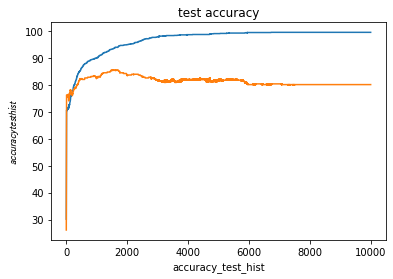

In [ ]:
plt.figure()
plt.plot(accuracy_train_hist)
plt.xlabel('accuracy_train_hist')
plt.ylabel('$\mathcal{accuracy train hist}$')
plt.title('train accuracy')

plt.plot(accuracy_test_hist)
plt.xlabel('accuracy_test_hist')
plt.ylabel('$\mathcal{accuracy test hist}$')
plt.title('test accuracy')
plt.show()

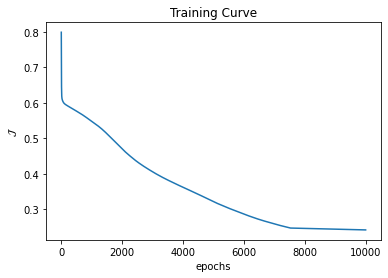

Training metrics:
true_pos= 395, false_neg= 45, false_pos= 87, true_neg= 973
{'accuracy': 91.2, 'precision': 81.95, 'recall': 89.77, 'f1': 85.68}
Testing metrics:
true_pos= 59, false_neg= 29, false_pos= 38, true_neg= 238
{'accuracy': 81.59, 'precision': 60.82, 'recall': 67.05, 'f1': 63.78}


In [ ]:
myAnn = ANN([8, 8, 8, 8], [ReLU, np.tanh, np.tanh, sigmoid])
accuracy_train_hist, accuracy_test_hist = myAnn.fit(X_train, y_train, X_test, y_test, eta = 5e-2, epochs = 1e4, show_curve = True, measure_metrics = True)
y_hat_train_4_8_8_8_8_sigmoid_3_1_1_4_v3 = myAnn.predict(X_train)
y_hat_test_4_8_8_8_8_sigmoid_3_1_1_4_v3 = myAnn.predict(X_test)
print('Training metrics:')
print(get_metrics(y_train, y_hat_train_4_8_8_8_8_sigmoid_3_1_1_4_v3, print_pos_neg = True))
print('Testing metrics:')
print(get_metrics(y_test, y_hat_test_4_8_8_8_8_sigmoid_3_1_1_4_v3, print_pos_neg = True))

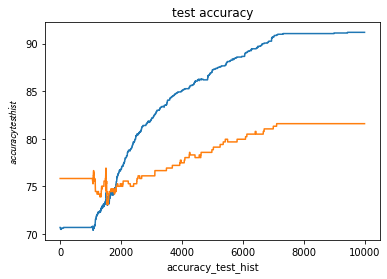

In [ ]:
plt.figure()
plt.plot(accuracy_train_hist)
plt.xlabel('accuracy_train_hist')
plt.ylabel('$\mathcal{accuracy train hist}$')
plt.title('train accuracy')

plt.plot(accuracy_test_hist)
plt.xlabel('accuracy_test_hist')
plt.ylabel('$\mathcal{accuracy test hist}$')
plt.title('test accuracy')
plt.show()

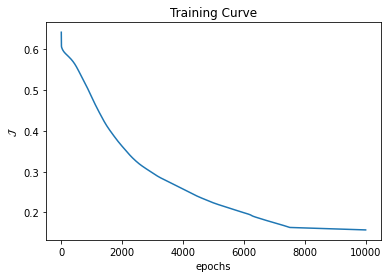

Training metrics:
true_pos= 393, false_neg= 47, false_pos= 47, true_neg= 1013
{'accuracy': 93.73, 'precision': 89.32, 'recall': 89.32, 'f1': 89.32}
Testing metrics:
true_pos= 70, false_neg= 18, false_pos= 38, true_neg= 238
{'accuracy': 84.62, 'precision': 64.81, 'recall': 79.55, 'f1': 71.43}


In [ ]:
myAnn = ANN([8, 8, 8, 8], [ReLU, np.tanh, np.tanh, sigmoid])
accuracy_train_hist, accuracy_test_hist = myAnn.fit(X_train, y_train, X_test, y_test, eta = 1e-1, epochs = 1e4, show_curve = True, measure_metrics = True)
y_hat_train_4_8_8_8_8_sigmoid_1_1_1_4_v3 = myAnn.predict(X_train)
y_hat_test_4_8_8_8_8_sigmoid_1_1_1_4_v3 = myAnn.predict(X_test)
print('Training metrics:')
print(get_metrics(y_train, y_hat_train_4_8_8_8_8_sigmoid_1_1_1_4_v3, print_pos_neg = True))
print('Testing metrics:')
print(get_metrics(y_test, y_hat_test_4_8_8_8_8_sigmoid_1_1_1_4_v3, print_pos_neg = True))

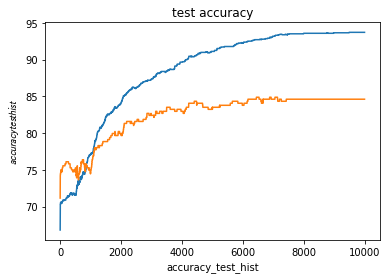

In [ ]:
plt.figure()
plt.plot(accuracy_train_hist)
plt.xlabel('accuracy_train_hist')
plt.ylabel('$\mathcal{accuracy train hist}$')
plt.title('train accuracy')

plt.plot(accuracy_test_hist)
plt.xlabel('accuracy_test_hist')
plt.ylabel('$\mathcal{accuracy test hist}$')
plt.title('test accuracy')
plt.show()

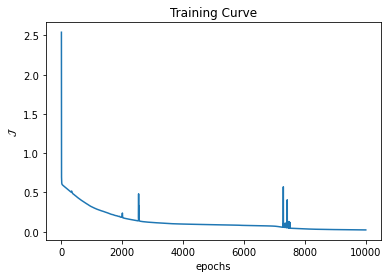

Training metrics:
true_pos= 437, false_neg= 3, false_pos= 5, true_neg= 1055
{'accuracy': 99.47, 'precision': 98.87, 'recall': 99.32, 'f1': 99.09}
Testing metrics:
true_pos= 61, false_neg= 27, false_pos= 50, true_neg= 226
{'accuracy': 78.85, 'precision': 54.95, 'recall': 69.32, 'f1': 61.3}


In [ ]:
myAnn = ANN([8, 8, 8, 8], [ReLU, np.tanh, np.tanh, np.tanh])
accuracy_train_hist, accuracy_test_hist = myAnn.fit(X_train, y_train, X_test, y_test, eta = 2e-1, epochs = 1e4, show_curve = True, measure_metrics = True)
y_hat_train_4_8_8_8_8_tanh_2_1_1_4_v3 = myAnn.predict(X_train)
y_hat_test_4_8_8_8_8_tanh_2_1_1_4_v3 = myAnn.predict(X_test)
print('Training metrics:')
print(get_metrics(y_train, y_hat_train_4_8_8_8_8_tanh_2_1_1_4_v3, print_pos_neg = True))
print('Testing metrics:')
print(get_metrics(y_test, y_hat_test_4_8_8_8_8_tanh_2_1_1_4_v3, print_pos_neg = True))

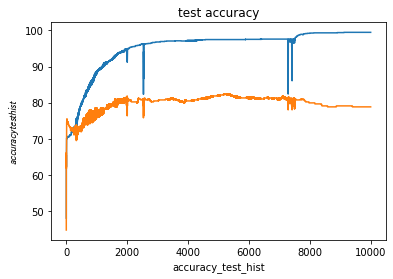

In [ ]:
plt.figure()
plt.plot(accuracy_train_hist)
plt.xlabel('accuracy_train_hist')
plt.ylabel('$\mathcal{accuracy train hist}$')
plt.title('train accuracy')

plt.plot(accuracy_test_hist)
plt.xlabel('accuracy_test_hist')
plt.ylabel('$\mathcal{accuracy test hist}$')
plt.title('test accuracy')
plt.show()

## Best ANN performance so far is 4 hidden layers all with 8 nodes. Relu, tanh, tanh, tanh activations respectively. imbalanced data sets, 1500 training samples, eta = 3e-1 (possibly variable eta), epochs = 1e4.

# Using Keras to build the same neural nets.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow_datasets as tfds

In [ ]:
def remove_html(text):
    soup = BeautifulSoup(text, 'lxml')
    html_free = soup.get_text()
    return html_free

def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation and c not in string.digits])
    return no_punct

def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [ ]:
df = pd.read_csv('UglyWordsPETER.csv')
df['clean'] = df['Input'].apply(lambda x: remove_punctuation(x))
df['clean']

0                         screams in  different languages
1       Families to sue over Legionnaires More than  f...
2       Pandemonium In Aba As Woman Delivers Baby With...
3       My emotions are a train wreck My body is a tra...
4       Alton brown just did a livestream and he burne...
                              ...                        
1859    Trollkrattos Juan Carlos Salvador The Secret T...
1860    devonbreneman hopefully it doesnt electrocute ...
1861    Businesses are deluged with invokces Make your...
1862    BREAKING  police officers arrested for abusing...
1863    News Refugio oil spill may have been costlier ...
Name: clean, Length: 1864, dtype: object

In [ ]:
import numpy as np
import pandas as pd
import re
import pickle
import nltk
import string

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Bidirectional,Flatten,Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

In [ ]:
df['clean'] = df['clean'].apply(lambda x: remove_html(x))

In [ ]:
df['clean'] = df['clean'].apply(lambda x: remove_stopwords(x))
df['clean']

LookupError: ignored

In [ ]:
df['clean'] = df['clean'].apply(lambda x: remove_html(x))

In [ ]:
tokenizer1 = RegexpTokenizer(r'\w+')

In [ ]:
df['clean'] = df['clean'].apply(lambda x: tokenizer1.tokenize(x.lower()))
df['clean']

0                     [screams, in, different, languages]
1       [families, to, sue, over, legionnaires, more, ...
2       [pandemonium, in, aba, as, woman, delivers, ba...
3       [my, emotions, are, a, train, wreck, my, body,...
4       [alton, brown, just, did, a, livestream, and, ...
                              ...                        
1859    [trollkrattos, juan, carlos, salvador, the, se...
1860    [devonbreneman, hopefully, it, doesnt, electro...
1861    [businesses, are, deluged, with, invokces, mak...
1862    [breaking, police, officers, arrested, for, ab...
1863    [news, refugio, oil, spill, may, have, been, c...
Name: clean, Length: 1864, dtype: object

In [ ]:
df['clean'] = df['clean'].apply(lambda x: remove_stopwords(x))
df['clean']

LookupError: ignored

# LSTM

In [ ]:
class Layer(torch.nn.Module):

  def __init__(self, size_in, size_out, activation):
  # size_out defines this layer's nodes.
    super(Layer, self).__init__()
    # It is torch's way of injecting parameters into the class.
    self.weights = torch.nn.Parameter(torch.randn(size_in, size_out, requires_grad = True))
    self.bias = torch.nn.Parameter(torch.randn(1, size_out, requires_grad = True))
    self.activation = activation

  def forward(self, z_in):
    return self.activation(z_in@self.weights + self.bias)

In [ ]:
# forget = Layer(512, 15, torch.nn.Sigmoid())
# # Mean Square Error Loss
# loss_func = torch.nn.MSELoss()
# # Optimization
# opt = torch.optim.Adam(forget.parameters())

In [ ]:
# X_train = torch.from_numpy(X_train)
# type(X_train)
# y_train = torch.from_numpy(y_train)
# type(y_train)

In [ ]:
# print(forget.bias)
# out = forget.forward(X_train)
# print(out.shape)
# print(y_train.shape)
# loss = loss_func(out, y_train)
# # Does the backpropagation
# loss.backward()
# # Just do one epoch
# opt.step()
# opt.zero_grad()
# print(forget.bias)

Parameter containing:
tensor([[-0.2838, -1.2327, -0.5805,  0.8719,  0.6260, -0.5697,  0.0698,  0.1992,
          1.6327,  0.3334, -1.1010,  0.6734,  0.4121, -0.3924, -0.5425]],
       requires_grad=True)
torch.Size([1500, 15])
(1500,)


TypeError: ignored

In [ ]:
# # Recurrent Networks
# class RNN(torch.nn.Module):
#   def __init__(self, size_in, size_out, size_mem):
#     super(RNN, self).__init__()
#     self.size_mem = size_mem
#     self.mem_layer = Layer(size_in + size_mem, size_mem, torch.tanh)
#     self.out_layer = Layer(size_mem, size_out, torch.sigmoid)

#   def forward(self, X):
#     mem = torch.zeros(1, self.size_mem)
#     y_hat = []
#     for i in range(X.shape[0]):
#       x_in = X[[i], :]
#       z_in = torch.cat([x_in, mem], dim = 1)
#       mem = self.mem_layer.forward(z_in)
#       y_hat.append(self.out_layer.forward(mem))

#     return torch.cat(y_hat, dim = 0)

In [ ]:
# rnn = RNN(512, 15, 5)
# loss_func = torch.nn.MSELoss()
# # decides the type of gradient descient.
# opt = torch.optim.Adam(rnn.parameters())

In [ ]:
# print(rnn.mem_layer.bias)
# y_hat = rnn.forward(X_train)
# loss = loss_func(y_hat, y)
# loss.backward()
# opt.step()
# opt.zero_grad()
# print()
# print(rnn.mem_layer.bias)

Parameter containing:
tensor([[ 1.1948,  1.2167,  0.3311, -1.5199, -1.9711]], requires_grad=True)


TypeError: ignored

In [ ]:
class LSTM(torch.nn.Module):
  def __init__(self, size_in, size_out, size_long, size_short):
    super(LSTM, self).__init__()
    self.size_long = size_long
    self.size_short = size_short

    size_z = size_in + size_short
    
    # The first five are hiden layers.
    self.forget_gate  = Layer(size_z, size_long, torch.sigmoid)
    self.memory_gate  = Layer(size_z, size_long, torch.sigmoid)
    self.memory_layer = Layer(size_z, size_long, torch.tanh)
    self.recall_gate  = Layer(size_z, size_short, torch.sigmoid)
    self.recall_layer = Layer(size_long, size_short, torch.tanh)
    self.output_gate  = Layer(size_short, size_out, torch.sigmoid)

  def forward(self, X):
    mem_short = torch.zeros(1, self.size_short)
    mem_long = torch.zeros(1, self.size_long)
    y_hat = []
    # For all the rows
    for i in range(X.shape[0]):
      X_t = X[[i], :]
      z_t = torch.cat([X_t, mem_short], dim = 1)

      mem_long = mem_long * self.forget_gate.forward(z_t)
      mem_long = mem_long + (self.memory_gate.forward(z_t) * self.memory_layer.forward(z_t))
      mem_short = self.recall_gate.forward(z_t) * self.recall_layer.forward(mem_long)

      y_hat.append(self.output_gate.forward(mem_short))

    return torch.cat(y_hat, dim = 0)


  def generate(self, start, stop, random_factor):
    y_hat = [start]

    mem_long = torch.randn([1, self.size_long]) * random_factor
    mem_short = torch.randn([1, self.size_short]) * random_factor

    while (y_hat[-1] != stop).any() and len(y_hat) < 30:
      x_t = y_hat[-1]
      z_t = torch.cat([x_t, mem_short], dim = 1)
      mem_long = mem_long * self.forget_gate.forward(z_t)
      mem_long = mem_long + (self.memory_gate.forward(z_t) * self.memory_layer.forward(z_t))
      mem_short = self.recall_gate.forward(z_t) * self.recall_layer.forward(mem_long)
      out = self.output_gate.forward(mem_short)
      out = torch.argmax(out, dim = 1)

      y_hat.append(torch.zeros(stop.shape))
      y_hat[-1][0, out] = 1
    return torch.cat(y_hat, dim = 0)

In [ ]:
def Process(name):
  name = ''.join(['{', name, '|'])
  out = []
  for letter in name:
    # Here LSTM just predicts the next letter.
    row = torch.zeros([1, 28])
    # 97 is the ascii code for 'a'.
    row[0, ord(letter) - 97] = 1
    out.append(row)
  return torch.cat(out)

def Decode(y_hat):
  out = ''
  for i in torch.argmax(y_hat, dim = 1):
    out += chr(i + 97)
  return out

## Define our LSTM

In [ ]:
# There are 512 input (one for each member of the embedder vector), and 2 output lines.
# Only one of the output lines is active at the same time.
# We use argmax at the output to make sure that only one of them is active.
lstm = LSTM(512, 2, 12, 12)
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.AdamW(lstm.parameters(), lr = 4.5e-2)

In [ ]:
X_train.shape

(1500, 512)

In [ ]:
iterations = 4600
losses =[0]
name = '{'

for i in range(iterations):
  name = Process(np.random.choice(X_train))
  y_hat = lstm.forward(name)
  # print('\r Iteration: {} Loss:{} |{}'.format(i, loss-1, Decode(y_hat)) + '   ')
  loss = loss_func(y_hat[:-1], torch.argmax(name, dim = 1)[1:])
  print('\r Iteration: {} Loss:{} |{}'.format(i, loss-1, Decode(y_hat)) + '   ')
  loss.backward()
  losses.append(loss.detach())
  opt.step()
  opt.zero_grad()

  plt.plot(losses)

ValueError: ignored

In [ ]:
for i in range(100):
  print(Decode(lstm.generate(Process('{')[[1]], Process('')[[1]], 1)))